In [22]:
# Theme selector for matplotlib plots (manual, simple, no external scripts)
import matplotlib.pyplot as plt
import ipywidgets as widgets

THEMES = {
    "Light": {
        "bg": "#ffffff",
        "fg": "#222222",
        "grid": "#cccccc"
    },
    "Night Blues": {
        "bg": "#0a192f",
        "fg": "#e6e6e6",
        "grid": "#1f4068"
    },
    "Dark+": {
        "bg": "#1e1e1e",
        "fg": "#d4d4d4",
        "grid": "#444444"
    }
}

def set_theme(theme="Light"):
    colors = THEMES[theme]
    plt.rcParams.update({
        "figure.facecolor": colors["bg"],
        "axes.facecolor": colors["bg"],
        "axes.edgecolor": colors["fg"],
        "axes.labelcolor": colors["fg"],
        "xtick.color": colors["fg"],
        "ytick.color": colors["fg"],
        "text.color": colors["fg"],
        "grid.color": colors["grid"],
        "savefig.facecolor": colors["bg"],
        "savefig.edgecolor": colors["bg"]
    })

widgets.interact(set_theme, theme=widgets.Dropdown(options=list(THEMES.keys()), value="Light"))

interactive(children=(Dropdown(description='theme', options=('Light', 'Night Blues', 'Dark+'), value='Light'),…

<function __main__.set_theme(theme='Light')>

In [23]:
# Ensure interact is imported
from ipywidgets import interact, FloatSlider


# Interactive Line Search Visualization

This notebook provides **interactive visualizations** of line search methods for understanding optimization algorithms.

## 📚 What You'll Learn

1. How line search finds step sizes
2. Comparison of different methods (Backtracking, Wolfe, Exact)
3. Interactive parameter exploration
4. Real-time convergence analysis

In [24]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Dropdown

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Part 1: Visualizing the φ(α) Function

**Description:**
This section introduces the concept of the line search merit function $\phi(\alpha) = f(\mathbf{x}_k + \alpha \mathbf{d}_k)$, which is central to line search methods in optimization. The merit function reduces the multidimensional optimization problem to a one-dimensional search for the optimal step size $\alpha$.
 
**Theory:**
- The merit function $\phi(\alpha)$ describes how the objective function changes as we move from the current point $\mathbf{x}_k$ along the search direction $\mathbf{d}_k$ by a step size $\alpha$.
- The goal is to find an $\alpha$ that sufficiently decreases $f$ and ensures efficient convergence.
- The derivative $\phi'(\alpha)$ provides information about the slope and is used in conditions like Armijo and Wolfe.
- Visualizing $\phi(\alpha)$ helps understand the behavior of different line search strategies and their impact on optimization.

We'll use a simple quadratic example: $f(x,y) = x^2 + 4y^2$

In [25]:
# Define our test function and phi(alpha)
def f(x, y):
    """Test function: f(x,y) = x² + 4y²"""
    return x**2 + 4*y**2

def grad_f(x, y):
    """Gradient of f"""
    return np.array([2*x, 8*y])

def phi(alpha, x_k, d_k):
    """Merit function: φ(α) = f(x_k + α·d_k)"""
    x_new = x_k + alpha * d_k
    return f(x_new[0], x_new[1])

def phi_derivative(alpha, x_k, d_k):
    """Derivative: φ'(α) = ∇f(x_k + α·d_k)ᵀ d_k"""
    x_new = x_k + alpha * d_k
    grad = grad_f(x_new[0], x_new[1])
    return np.dot(grad, d_k)

print("✅ Functions defined!")

✅ Functions defined!


### Interactive φ(α) Explorer

**Try changing the starting point** and see how φ(α) changes!

In [ ]:
@interact(
    x0=FloatSlider(min=0.5, max=3.0, step=0.1, value=2.0, description='x₀'),
    y0=FloatSlider(min=0.5, max=2.0, step=0.1, value=1.0, description='y₀'),
    c=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.1, description='c (Armijo)')
)
def plot_phi_interactive(x0=2.0, y0=1.0, c=0.1):
    import matplotlib
    matplotlib.rcParams['font.family'] = 'DejaVu Sans'
    
    x_k = np.array([x0, y0])
    grad = grad_f(x_k[0], x_k[1])
    d_k = -grad
    
    alpha_range = np.linspace(0, 0.4, 1000)
    phi_values = [phi(a, x_k, d_k) for a in alpha_range]
    
    from scipy.optimize import minimize_scalar
    result = minimize_scalar(lambda a: phi(a, x_k, d_k), bounds=(0, 1), method='bounded')
    # Fix: handle both dict and object result types for minimize_scalar
    if isinstance(result, dict):
        alpha_exact = result.get('x', None)
        phi_exact = result.get('fun', None)
    else:
        alpha_exact = getattr(result, 'x', None)
        phi_exact = getattr(result, 'fun', None)
    
    phi_0 = phi(0, x_k, d_k)
    phi_prime_0 = phi_derivative(0, x_k, d_k)
    armijo_line = phi_0 + c * alpha_range * phi_prime_0
    
    alpha_bt = 1.0
    rho = 0.5
    while phi(alpha_bt, x_k, d_k) > phi_0 + c * alpha_bt * phi_prime_0:
        alpha_bt *= rho
        if alpha_bt < 1e-10:
            break
    phi_bt = phi(alpha_bt, x_k, d_k)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(alpha_range, phi_values, 'b-', linewidth=2.5, label='φ(α) = f($x_k$ + α·$d_k$)')
    ax1.plot(alpha_range, armijo_line, 'r--', linewidth=2, label=f'Armijo: φ(0) + {c}·α·φ\'(0)')
    if alpha_exact is not None and phi_exact is not None:
        ax1.plot(alpha_exact, phi_exact, 'go', markersize=12, label=f'Exact min (α={alpha_exact:.4f})', zorder=5)
    ax1.plot(alpha_bt, phi_bt, 'rs', markersize=12, label=f'Backtracking (α={alpha_bt:.4f})', zorder=5)
    ax1.axhline(y=phi_0, color='gray', linestyle=':', alpha=0.5)
    ax1.fill_between(alpha_range, 0, armijo_line, where=(np.array(phi_values) <= armijo_line), 
                      alpha=0.2, color='green', label='Acceptable region')
    ax1.set_xlabel('Step size α', fontsize=14, fontweight='bold')
    ax1.set_ylabel('φ(α)', fontsize=14, fontweight='bold')
    ax1.set_title(f'Line Search from ($x_k$={x0:.1f}, {y0:.1f})', fontsize=16, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 0.4)
    
    x = np.linspace(-0.5, 3.5, 100)
    y = np.linspace(-0.5, 2.5, 100)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 4*Y**2
    contour = ax2.contour(X, Y, Z, levels=20, alpha=0.6, cmap='viridis')
    ax2.clabel(contour, inline=True, fontsize=8)
    alpha_line = np.linspace(0, 0.4, 50)
    search_path = np.array([x_k + a * d_k for a in alpha_line])
    ax2.plot(search_path[:, 0], search_path[:, 1], 'b-', linewidth=2, alpha=0.7, label='Search direction')
    ax2.plot(x_k[0], x_k[1], 'ko', markersize=12, label=f'Start $x_k$=({x0:.1f},{y0:.1f})', zorder=5)
    if alpha_exact is not None:
        x_exact = x_k + alpha_exact * d_k
        ax2.plot(x_exact[0], x_exact[1], 'go', markersize=12, label='Exact LS', zorder=5)
    x_bt = x_k + alpha_bt * d_k
    ax2.plot(x_bt[0], x_bt[1], 'rs', markersize=12, label='Backtracking', zorder=5)
    ax2.plot(0, 0, 'r*', markersize=15, label='Global min (0,0)', zorder=5)
    ax2.arrow(x_k[0], x_k[1], -grad[0]*0.15, -grad[1]*0.15, 
              head_width=0.15, head_length=0.1, fc='red', ec='red', linewidth=2, alpha=0.7)
    ax2.set_xlabel('x', fontsize=14, fontweight='bold')
    ax2.set_ylabel('y', fontsize=14, fontweight='bold')
    ax2.set_title('Function Contours & Search Direction', fontsize=16, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    plt.tight_layout()
    plt.show()
    print(f"\n{'='*60}")
    print(f"Starting point: ({x0:.2f}, {y0:.2f}), f = {phi_0:.4f}")
    print(f"Gradient: [{grad[0]:.2f}, {grad[1]:.2f}]")
    print(f"\nComparison:")
    if alpha_exact is not None and phi_exact is not None:
        print(f"  Exact Line Search:  α = {alpha_exact:.6f}, φ(α) = {phi_exact:.6f}")
    print(f"  Backtracking:       α = {alpha_bt:.6f}, φ(α) = {phi_bt:.6f}")
    if alpha_exact is not None and phi_exact is not None:
        print(f"  Difference:         Δα = {abs(alpha_exact-alpha_bt):.6f}, Δφ = {abs(phi_exact-phi_bt):.6f}")
        print(f"  Efficiency:         Backtracking ≈ {(phi_exact/phi_bt)*100:.1f}% as good as exact")
    print(f"{'='*60}")

interactive(children=(FloatSlider(value=2.0, description='x₀', max=3.0, min=0.5), FloatSlider(value=1.0, descr…

## Part 2: Comparing Line Search Methods

**Description:**
This section implements and compares the main line search strategies used in gradient-based optimization: Backtracking (Armijo), Wolfe conditions, and Exact line search.
 
**Theory:**
- **Backtracking (Armijo):** Shrinks the step size $\alpha$ until a sufficient decrease in $f$ is achieved. Simple, robust, and efficient for most problems.
  
  **Armijo condition:**
  $$
  f(x_k + \alpha d_k) \leq f(x_k) + c \alpha \nabla f(x_k)^T d_k
  $$
- **Wolfe Conditions:** Ensures both sufficient decrease and appropriate curvature, making it ideal for quasi-Newton methods like BFGS.
  
  **Wolfe conditions:**
  1. Sufficient decrease (Armijo):
  $$
  f(x_k + \alpha d_k) \leq f(x_k) + c_1 \alpha \nabla f(x_k)^T d_k
  $$
  2. Curvature condition:
  $$
  |\nabla f(x_k + \alpha d_k)^T d_k| \leq c_2 |\nabla f(x_k)^T d_k|
  $$
- **Exact Line Search:** Finds the optimal $\alpha$ along the search direction, but is computationally expensive and mainly used for quadratic or special cases.
  
  **Exact line search:**
  $$
  \alpha^* = \arg\min_{\alpha > 0} f(x_k + \alpha d_k)
  $$
- The choice of line search method affects convergence rate, computational cost, and stability.
- Visual comparison helps understand the strengths and trade-offs of each approach.

In [ ]:
def backtracking_line_search(f_func, grad_func, x_k, d_k, alpha_init=1.0, rho=0.5, c=1e-4, max_iter=50):
    """
    Backtracking line search with Armijo condition.
    
    Math Theory:
    - The Armijo condition ensures sufficient decrease:
      $$
      f(x_k + \alpha d_k) \leq f(x_k) + c \alpha \nabla f(x_k)^T d_k
      $$
    - The algorithm shrinks $\alpha$ by $\rho$ until the condition is met.
    - Guarantees global convergence for convex functions.
    """
    alpha = alpha_init
    f_k = f_func(x_k[0], x_k[1])
    grad_k = grad_func(x_k[0], x_k[1])
    
    grad_d = np.dot(grad_k, d_k)
    evals = 0
    
    for i in range(max_iter):
        x_new = x_k + alpha * d_k
        f_new = f_func(x_new[0], x_new[1])
        evals += 1
        
        if f_new <= f_k + c * alpha * grad_d:
            return alpha, evals
        
        alpha *= rho
    
    return alpha, evals

def wolfe_line_search(f_func, grad_func, x_k, d_k, alpha_init=1.0, c1=1e-4, c2=0.9, max_iter=50):
    """
    Line search satisfying Wolfe conditions.
    
    Math Theory:
    - Wolfe conditions require:
      1. Sufficient decrease (Armijo):
         $$
         f(x_k + \alpha d_k) \leq f(x_k) + c_1 \alpha \nabla f(x_k)^T d_k
         $$
      2. Curvature condition:
         $$
         |\nabla f(x_k + \alpha d_k)^T d_k| \leq c_2 |\nabla f(x_k)^T d_k|
         $$
    - Ensures both decrease and that the gradient is sufficiently flat.
    - Preferred for quasi-Newton methods (e.g., BFGS).
    """
    alpha = alpha_init
    f_k = f_func(x_k[0], x_k[1])
    grad_k = grad_func(x_k[0], x_k[1])
    grad_d_k = np.dot(grad_k, d_k)
    evals = 0
    
    for i in range(max_iter):
        x_new = x_k + alpha * d_k
        f_new = f_func(x_new[0], x_new[1])
        grad_new = grad_func(x_new[0], x_new[1])
        grad_d_new = np.dot(grad_new, d_k)
        evals += 2  # Function + gradient
        
        # Check Armijo condition
        if f_new > f_k + c1 * alpha * grad_d_k:
            alpha *= 0.5
            continue
        
        # Check curvature condition
        if grad_d_new < c2 * grad_d_k:
            alpha *= 1.5
            continue
        
        return alpha, evals
    
    return alpha, evals

def exact_line_search(f_func, x_k, d_k):
    """
    Exact line search (for comparison).
    
    Math Theory:
    - Finds the exact minimizer of the merit function:
      $$
      \alpha^* = \arg\min_{\alpha > 0} f(x_k + \alpha d_k)
      $$
    - For quadratic functions, the solution can be found analytically.
    - For general functions, numerical optimization (e.g., Brent's method) is used.
    """
    from scipy.optimize import minimize_scalar
    result = minimize_scalar(lambda a: f_func((x_k + a * d_k)[0], (x_k + a * d_k)[1]), 
                            bounds=(0, 10), method='bounded')
    alpha_exact = getattr(result, 'x', None)
    nfev = getattr(result, 'nfev', None)
    # Ensure nfev is not None before using it
    nfev_safe = nfev if nfev is not None else 0
    return alpha_exact, nfev_safe

print("✅ Line search methods implemented!")

✅ Line search methods implemented!


### Full Gradient Descent with Different Line Searches

In [33]:
def gradient_descent(f_func, grad_func, x0, method='backtracking', max_iter=50, tol=1e-6):
    """Gradient descent with specified line search method"""
    x = np.array(x0, dtype=float)
    path = [x.copy()]
    alphas = []
    f_values = [f_func(x[0], x[1])]
    total_evals = 0
    
    for i in range(max_iter):
        grad = grad_func(x[0], x[1])
        
        if np.linalg.norm(grad) < tol:
            break
        
        d = -grad  # Steepest descent
        
        # Line search
        if method == 'backtracking':
            alpha, evals = backtracking_line_search(f_func, grad_func, x, d)
        elif method == 'wolfe':
            alpha, evals = wolfe_line_search(f_func, grad_func, x, d)
        elif method == 'exact':
            alpha, evals = exact_line_search(f_func, x, d)
        else:
            alpha, evals = 0.1, 1  # Fixed step
        
        total_evals += evals
        alphas.append(alpha)
        x = x + alpha * d
        path.append(x.copy())
        f_values.append(f_func(x[0], x[1]))
    
    return np.array(path), alphas, f_values, total_evals

# Run all methods
x0 = [2.0, 1.0]
results = {}

for method in ['backtracking', 'wolfe', 'exact']:
    path, alphas, f_vals, evals = gradient_descent(f, grad_f, x0, method=method)
    results[method] = {'path': path, 'alphas': alphas, 'f_vals': f_vals, 'evals': evals}
    print(f"{method.upper():15} | Iterations: {len(path)-1:3d} | Evaluations: {evals:4d} | Final f: {f_vals[-1]:.2e}")

BACKTRACKING    | Iterations:   8 | Evaluations:   24 | Final f: 0.00e+00
WOLFE           | Iterations:   8 | Evaluations:   48 | Final f: 0.00e+00
EXACT           | Iterations:  25 | Evaluations:  201 | Final f: 2.97e-14


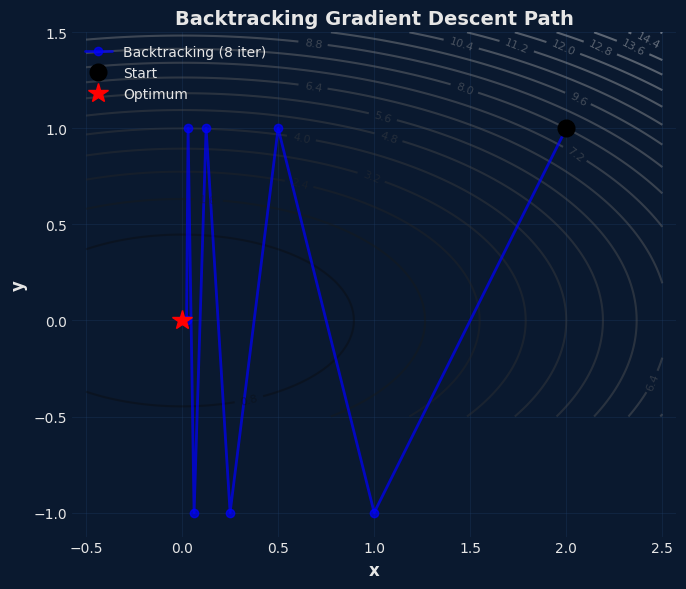

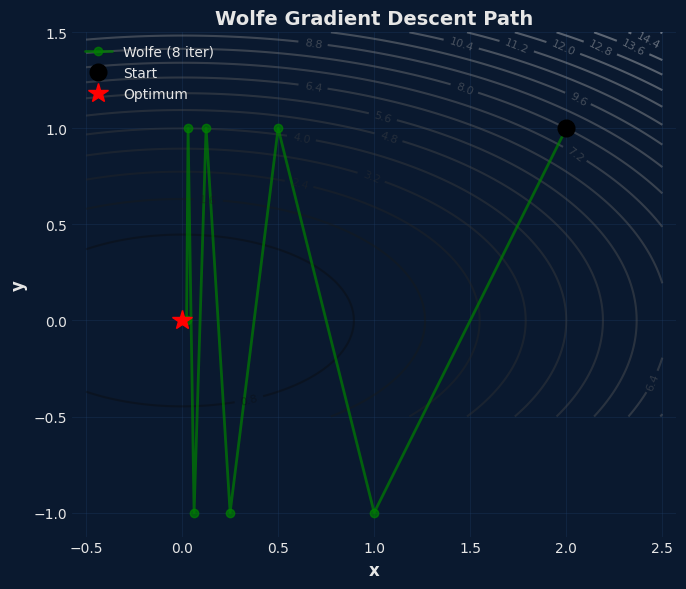

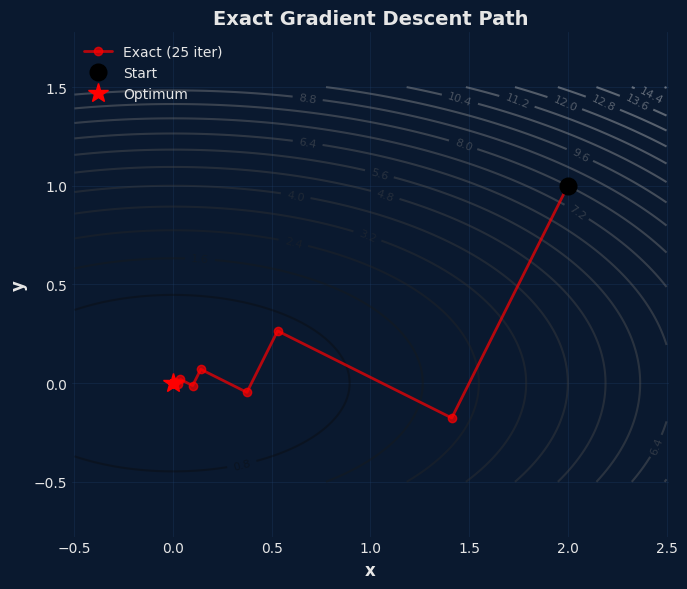

In [34]:
# Plot convergence path for each gradient method (no animation)
methods = ['backtracking', 'wolfe', 'exact']
colors = {'backtracking': 'blue', 'wolfe': 'green', 'exact': 'red'}
for method in methods:
    path = results[method]['path']
    fig, ax = plt.subplots(figsize=(7, 6))
    x = np.linspace(-0.5, 2.5, 100)
    y = np.linspace(-0.5, 1.5, 100)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 4*Y**2
    contour = ax.contour(X, Y, Z, levels=20, alpha=0.4, cmap='gray')
    ax.clabel(contour, inline=True, fontsize=8)
    ax.plot(path[:, 0], path[:, 1], 'o-', color=colors[method], linewidth=2, markersize=6, label=f'{method.capitalize()} ({len(path)-1} iter)', alpha=0.7)
    ax.plot(path[0, 0], path[0, 1], 'ko', markersize=12, label='Start', zorder=5)
    ax.plot(0, 0, 'r*', markersize=15, label='Optimum', zorder=5)
    ax.set_xlabel('x', fontsize=12, fontweight='bold')
    ax.set_ylabel('y', fontsize=12, fontweight='bold')
    ax.set_title(f'{method.capitalize()} Gradient Descent Path', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

### Visual Comparison of All Methods

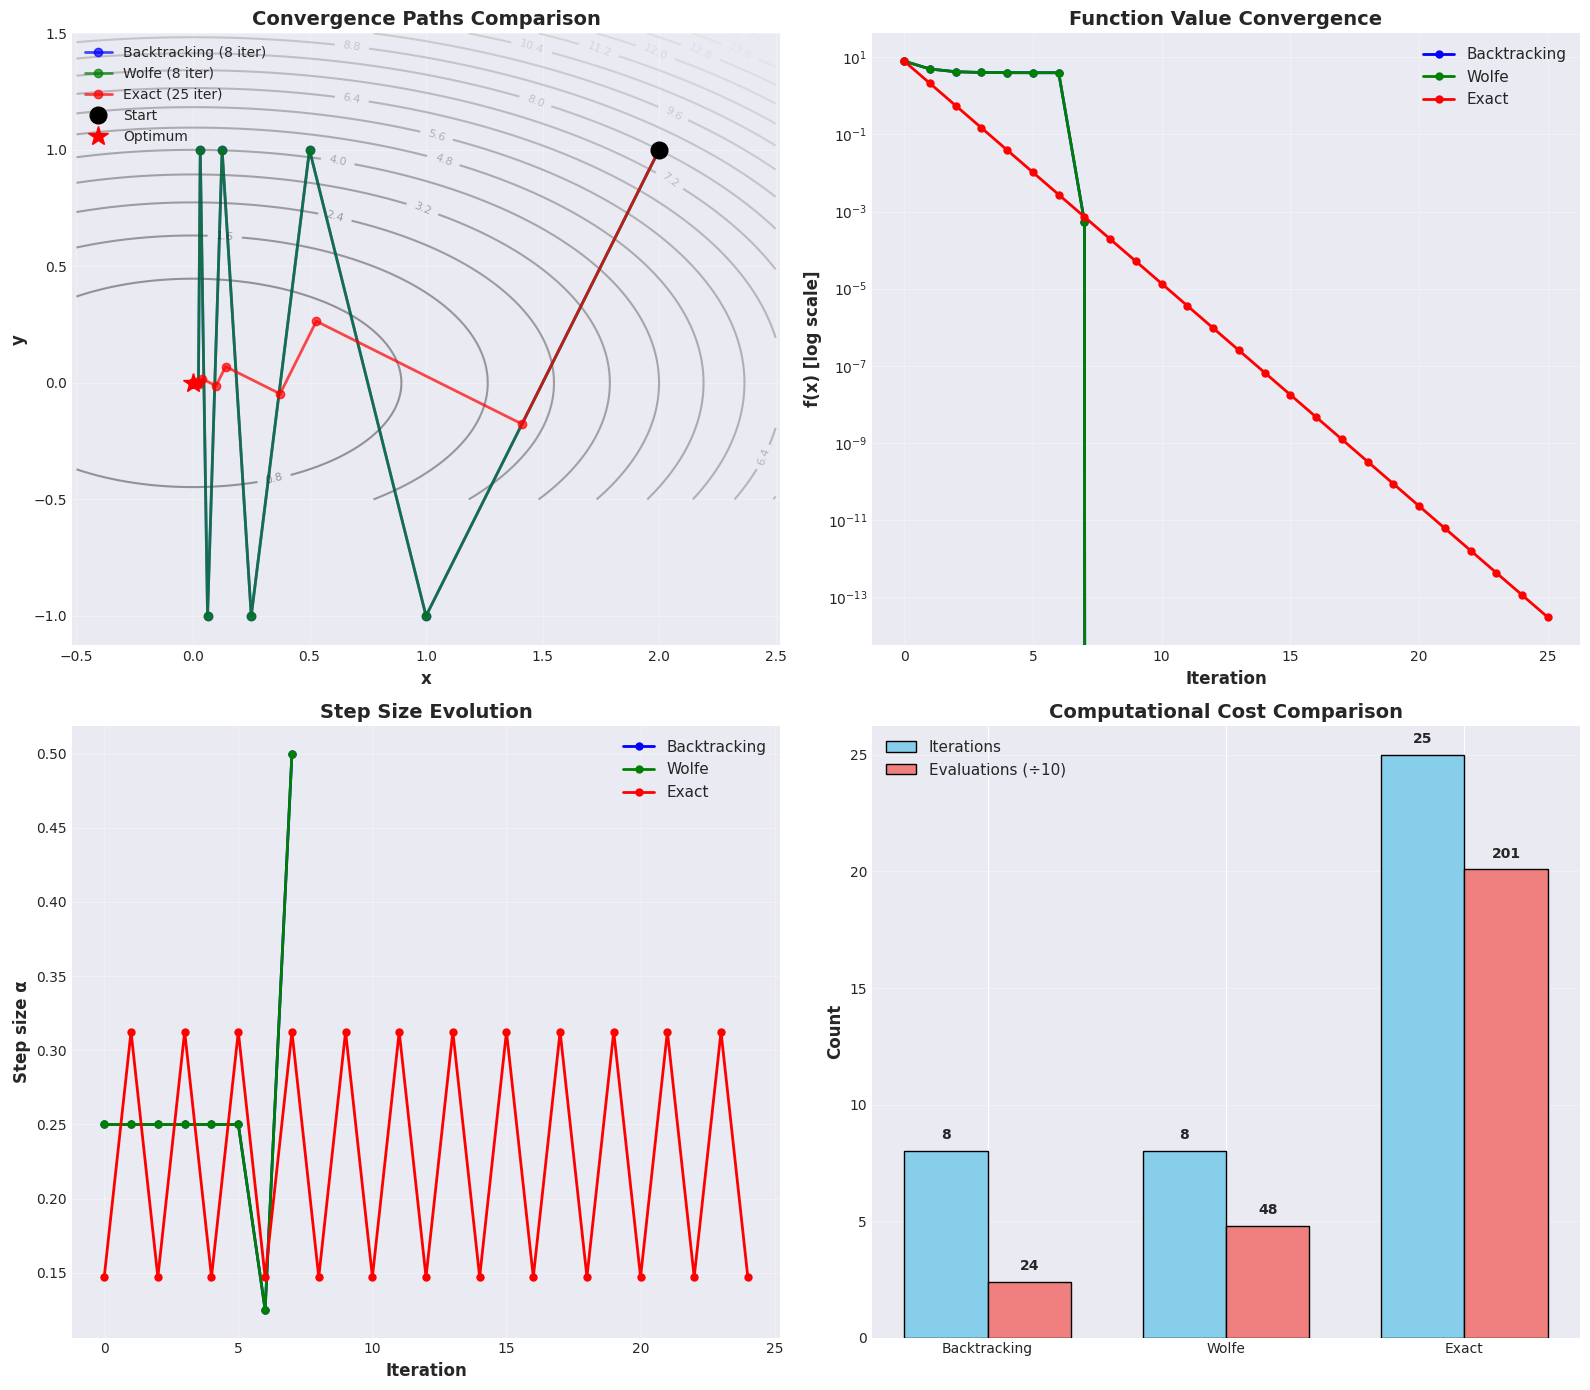


FINAL COMPARISON
Method          Iterations   Evaluations     Final f(x)     
----------------------------------------------------------------------
Backtracking    8            24              0.00e+00       
Wolfe           8            48              0.00e+00       
Exact           25           201             2.97e-14       


In [18]:
# Visual Comparison of All Methods (fix: ensure plt is imported)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Contour plot
x = np.linspace(-0.5, 2.5, 100)
y = np.linspace(-0.5, 1.5, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + 4*Y**2

# Plot 1: Convergence paths
ax = axes[0, 0]
contour = ax.contour(X, Y, Z, levels=20, alpha=0.4, cmap='gray')
ax.clabel(contour, inline=True, fontsize=8)

colors = {'backtracking': 'blue', 'wolfe': 'green', 'exact': 'red'}
for method, data in results.items():
    path = data['path']
    ax.plot(path[:, 0], path[:, 1], 'o-', color=colors[method], 
            linewidth=2, markersize=6, label=f'{method.capitalize()} ({len(path)-1} iter)', alpha=0.7)

ax.plot(x0[0], x0[1], 'ko', markersize=12, label='Start', zorder=5)
ax.plot(0, 0, 'r*', markersize=15, label='Optimum', zorder=5)
ax.set_xlabel('x', fontsize=12, fontweight='bold')
ax.set_ylabel('y', fontsize=12, fontweight='bold')
ax.set_title('Convergence Paths Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Function value convergence
ax = axes[0, 1]
for method, data in results.items():
    ax.semilogy(data['f_vals'], 'o-', color=colors[method], linewidth=2, 
                markersize=5, label=method.capitalize())
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('f(x) [log scale]', fontsize=12, fontweight='bold')
ax.set_title('Function Value Convergence', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Step sizes
ax = axes[1, 0]
for method, data in results.items():
    if data['alphas']:  # Check if not empty
        ax.plot(data['alphas'], 'o-', color=colors[method], linewidth=2, 
                markersize=5, label=method.capitalize())
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Step size α', fontsize=12, fontweight='bold')
ax.set_title('Step Size Evolution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: Efficiency comparison (bar chart)
ax = axes[1, 1]
methods = list(results.keys())
iterations = [len(results[m]['path'])-1 for m in methods]
evaluations = [results[m]['evals'] for m in methods]
final_f = [results[m]['f_vals'][-1] for m in methods]

x_pos = np.arange(len(methods))
width = 0.35

ax.bar(x_pos - width/2, iterations, width, label='Iterations', color='skyblue', edgecolor='black')
ax.bar(x_pos + width/2, [e/10 for e in evaluations], width, label='Evaluations (÷10)', 
       color='lightcoral', edgecolor='black')

ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Computational Cost Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([m.capitalize() for m in methods])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (it, ev) in enumerate(zip(iterations, evaluations)):
    ax.text(i - width/2, it + 0.5, str(it), ha='center', fontweight='bold')
    ax.text(i + width/2, ev/10 + 0.5, str(ev), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FINAL COMPARISON")
print("="*70)
print(f"{'Method':<15} {'Iterations':<12} {'Evaluations':<15} {'Final f(x)':<15}")
print("-"*70)
for method in methods:
    data = results[method]
    print(f"{method.capitalize():<15} {len(data['path'])-1:<12} {data['evals']:<15} {data['f_vals'][-1]:<15.2e}")
print("="*70)

## Part 3: Parameter Sensitivity Analysis

**Description:**
This section explores how the parameters of line search methods (such as $\rho$ for shrinkage and $c$ for the Armijo condition) affect the convergence behavior of gradient descent.
 
**Theory:**
- Line search parameters control the aggressiveness and conservativeness of step size selection.
- $\rho$ (shrinkage factor) determines how quickly the step size is reduced during backtracking.
- $c$ (Armijo constant) sets the threshold for sufficient decrease.
- Proper tuning of these parameters is crucial for balancing convergence speed and stability.
- Sensitivity analysis helps identify robust settings for different optimization problems.

In [ ]:
@interact(
    rho=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.5, description='ρ (shrink)'),
    c=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.1, description='c (Armijo)')
)
def parameter_sensitivity(rho=0.5, c=0.1):
    """Explore how parameters affect backtracking performance"""
    
    def custom_backtracking(f_func, grad_func, x_k, d_k):
        alpha = 1.0
        f_k = f_func(x_k[0], x_k[1])
        grad_k = grad_func(x_k[0], x_k[1])
        grad_d = np.dot(grad_k, d_k)
        evals = 0
        
        for i in range(50):
            x_new = x_k + alpha * d_k
            f_new = f_func(x_new[0], x_new[1])
            evals += 1
            
            if f_new <= f_k + c * alpha * grad_d:
                return alpha, evals
            alpha *= rho
        
        return alpha, evals
    
    # Run gradient descent
    x = np.array([2.0, 1.0], dtype=float)
    path = [x.copy()]
    alphas = []
    total_evals = 0
    
    for i in range(50):
        grad = grad_f(x[0], x[1])
        if np.linalg.norm(grad) < 1e-6:
            break
        d = -grad
        alpha, evals = custom_backtracking(f, grad_f, x, d)
        alphas.append(alpha)
        total_evals += evals
        x = x + alpha * d
        path.append(x.copy())
    
    path = np.array(path)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Convergence path
    x_range = np.linspace(-0.5, 2.5, 100)
    y_range = np.linspace(-0.5, 1.5, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = X**2 + 4*Y**2
    
    ax1.contour(X, Y, Z, levels=20, alpha=0.4, cmap='gray')
    ax1.plot(path[:, 0], path[:, 1], 'bo-', linewidth=2, markersize=6)
    ax1.plot(path[0, 0], path[0, 1], 'go', markersize=12, label='Start')
    ax1.plot(0, 0, 'r*', markersize=15, label='Optimum')
    ax1.set_title(f'Convergence Path\nρ={rho:.1f}, c={c:.2f}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('y', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Step sizes
    ax2.plot(alphas, 'ro-', linewidth=2, markersize=6)
    ax2.set_title(f'Step Sizes Over Iterations', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('α', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nResults with ρ={rho:.2f}, c={c:.2f}:")
    print(f"  Iterations: {len(path)-1}")
    print(f"  Total function evaluations: {total_evals}")
    print(f"  Final error: {np.linalg.norm(path[-1]):.2e}")
    print(f"  Avg step size: {np.mean(alphas):.4f}")

interactive(children=(FloatSlider(value=0.5, description='ρ (shrink)', max=0.9, min=0.1), FloatSlider(value=0.…

## Summary & Key Takeaways

**Description:**
This section summarizes the practical lessons and theoretical insights gained from experimenting with line search methods in gradient-based optimization.
 
**Theory:**
- Backtracking is simple, efficient, and works well for most problems.
- Wolfe conditions provide stronger guarantees and are preferred for advanced methods like BFGS.
- Exact line search is rarely needed except for special cases due to its computational cost.
- Tuning line search parameters is essential for optimal performance.
- Understanding the theory behind line search helps in designing robust and efficient optimization algorithms.

**Next Steps:**
- Experiment with the interactive widgets
- Try different starting points
- Test on more complex functions
- Implement for your own optimization problems!

In [ ]:
# Fix for matplotlib import and subplots layout
import matplotlib.pyplot as plt

# Example: create one row with two plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ...existing code for plotting...
# axes[0] and axes[1] are your two subplots

RuntimeError: x must be a sequence

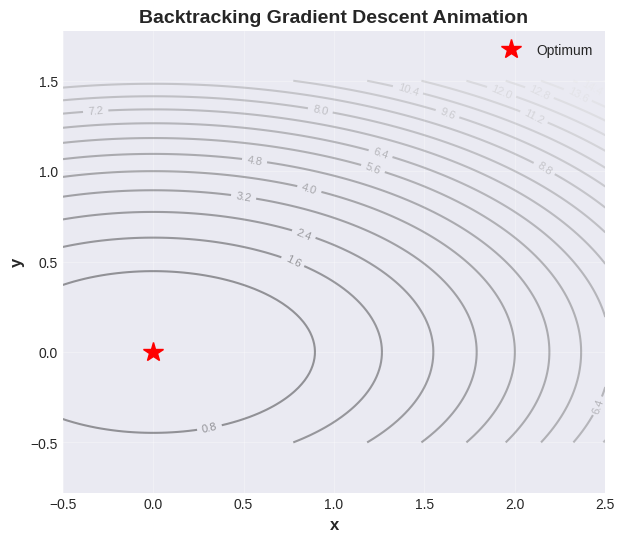

In [ ]:
# Animated convergence for each gradient method (fixed: start_point.set_data uses sequences)
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

methods = ['backtracking', 'wolfe', 'exact']
colors = {'backtracking': 'blue', 'wolfe': 'green', 'exact': 'red'}

for method in methods:
    path = results[method]['path']
    fig, ax = plt.subplots(figsize=(7, 6))
    x = np.linspace(-0.5, 2.5, 100)
    y = np.linspace(-0.5, 1.5, 100)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 4*Y**2
    contour = ax.contour(X, Y, Z, levels=20, alpha=0.4, cmap='gray')
    ax.clabel(contour, inline=True, fontsize=8)
    ax.plot(0, 0, 'r*', markersize=15, label='Optimum', zorder=5)
    ax.set_xlabel('x', fontsize=12, fontweight='bold')
    ax.set_ylabel('y', fontsize=12, fontweight='bold')
    ax.set_title(f'{method.capitalize()} Gradient Descent Animation', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    line, = ax.plot([], [], 'o-', color=colors[method], linewidth=2, markersize=6, label=method.capitalize())
    start_point, = ax.plot([], [], 'ko', markersize=12, label='Start', zorder=5)
    
    def init():
        line.set_data([], [])
        start_point.set_data([path[0, 0]], [path[0, 1]])  # Use sequences
        return line, start_point
    
    def animate(i):
        line.set_data(path[:i+1, 0], path[:i+1, 1])
        start_point.set_data([path[0, 0]], [path[0, 1]])  # Use sequences
        return line, start_point
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(path), interval=500, blit=True)
    plt.close(fig)
    display(HTML(anim.to_html5_video()))


In [ ]:
# Improved animation for Jupyter: use HTML5 video and fix start_point.set_data
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

methods = ['backtracking', 'wolfe', 'exact']
colors = {'backtracking': 'blue', 'wolfe': 'green', 'exact': 'red'}

for method in methods:
    path = results[method]['path']
    fig, ax = plt.subplots(figsize=(7, 6))
    x = np.linspace(-0.5, 2.5, 100)
    y = np.linspace(-0.5, 1.5, 100)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 4*Y**2
    contour = ax.contour(X, Y, Z, levels=20, alpha=0.4, cmap='gray')
    ax.clabel(contour, inline=True, fontsize=8)
    ax.plot(0, 0, 'r*', markersize=15, label='Optimum', zorder=5)
    ax.set_xlabel('x', fontsize=12, fontweight='bold')
    ax.set_ylabel('y', fontsize=12, fontweight='bold')
    ax.set_title(f'{method.capitalize()} Gradient Descent Animation', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    line, = ax.plot([], [], 'o-', color=colors[method], linewidth=2, markersize=6, label=method.capitalize())
    start_point, = ax.plot([], [], 'ko', markersize=12, label='Start', zorder=5)
    
    def init():
        line.set_data([], [])
        # set_data expects sequences, not scalars
        start_point.set_data([path[0, 0]], [path[0, 1]])
        return line, start_point
    
    def animate(i):
        line.set_data(path[:i+1, 0], path[:i+1, 1])
        start_point.set_data([path[0, 0]], [path[0, 1]])
        return line, start_point
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(path), interval=500, blit=True)
    plt.close(fig)
    display(HTML(anim.to_html5_video()))
